In [1]:
from load_feature import load_features
from datetime import datetime
from LSTM_model import video_classification
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

Using TensorFlow backend.


In [10]:
num_videos = 1000
skipnum = 0
num_frames = 30
h = 224
w = 224
c = 3

tic = datetime.now()
Xtrain, ytrain = load_features(num_videos, num_frames, h, w, c, skip_num=skipnum)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/num_videos1000_skipnum0_num_frame30.npz
Feature fusion time:  0:00:47.414372


In [4]:
num_classes = len(np.unique(ytrain))
lstm_model = video_classification(num_frames=30, num_classes=num_classes)

building model...


In [11]:
lstm_model.train(Xtr=Xtrain, ytr=ytrain, verbose=1, bsize=32, epochs=20)

Model is Training...
(1000, 30, 25088)
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 13s - loss: 2.8291 - acc: 0.2888 - val_loss: 2.4619 - val_acc: 0.3450
Epoch 2/20
800/800 [==============================] - 14s - loss: 2.2012 - acc: 0.4025 - val_loss: 2.4691 - val_acc: 0.3300
Epoch 3/20
800/800 [==============================] - 14s - loss: 1.9641 - acc: 0.4825 - val_loss: 2.3885 - val_acc: 0.3350
Epoch 4/20
800/800 [==============================] - 14s - loss: 1.7430 - acc: 0.5150 - val_loss: 2.4090 - val_acc: 0.3900
Epoch 5/20
800/800 [==============================] - 14s - loss: 1.7368 - acc: 0.5237 - val_loss: 2.5243 - val_acc: 0.3750
Epoch 6/20
800/800 [==============================] - 13s - loss: 1.5186 - acc: 0.6025 - val_loss: 2.5659 - val_acc: 0.3700
Epoch 7/20
800/800 [==============================] - 13s - loss: 1.4847 - acc: 0.6125 - val_loss: 2.7090 - val_acc: 0.3800
Epoch 8/20
800/800 [===========================

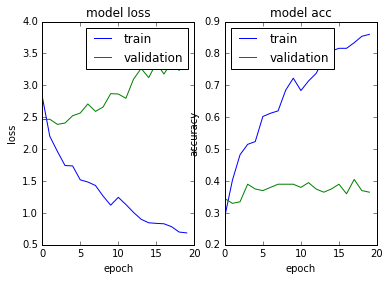

In [12]:
lstm_model.plot()

In [13]:
num_videos = 1000
skipnum = 0
num_frames = 30
h = 224
w = 224
c = 3

tic = datetime.now()
Xtrain_1, ytrain_1 = load_features(num_videos, num_frames, h, w, c, skip_num=skipnum)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/num_videos1000_skipnum0_num_frame30.npz
Feature fusion time:  0:00:10.385741


In [14]:
num_videos = 1000
skipnum = 1000
num_frames = 30
h = 224
w = 224
c = 3

tic = datetime.now()
Xtrain_2, ytrain_2 = load_features(num_videos, num_frames, h, w, c, skip_num=skipnum)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/num_videos1000_skipnum1000_num_frame30.npz
Feature fusion time:  0:00:47.317992


In [15]:
num_videos = 1000
skipnum = 2000
num_frames = 30
h = 224
w = 224
c = 3

tic = datetime.now()
Xtrain_3, ytrain_3 = load_features(num_videos, num_frames, h, w, c, skip_num=skipnum)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/num_videos1000_skipnum2000_num_frame30.npz
Feature fusion time:  0:00:10.291387


In [16]:
num_videos = 1000
skipnum = 3000
num_frames = 30
h = 224
w = 224
c = 3

tic = datetime.now()
Xtrain_4, ytrain_4 = load_features(num_videos, num_frames, h, w, c, skip_num=skipnum)
toc = datetime.now()
print('Feature fusion time: ', toc-tic)

find matched cache file /home/sunjiajun/cs231n_project/datasets/cache/num_videos1000_skipnum3000_num_frame30.npz
Feature fusion time:  0:00:11.380633
